# Pneumonia Detection from Chest X-Ray Images Using CNN

## Part 0 - Dataset Explanation

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Dataset could be dowloaded from Kaggle's following link: [Pneumonia Dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

### How a chest X-Ray Image help to detect Pneumonia?

Pneumonia is an acute pulmonary infection that can be caused by bacteria, viruses, or fungi and infects the lungs, causing inflammation of the air sacs and pleural effusion, a condition in which the lung is filled with fluid. It accounts for more than 15% of deaths in children under the age of five years.

Therefore, early diagnosis and management can play a pivotal role in preventing the disease from becoming fatal. Radiological examination of the lungs using computed tomography (CT), magnetic resonance imaging (MRI), or radiography (X-rays) is frequently used for diagnosis. X-ray imaging constitutes a non-invasive and relatively inexpensive examination of the lungs. Figures below are an example shows an example of a pneumonic and a healthy lung X-ray. The white spots in the pneumonic X-ray, called infiltrates, distinguish a pneumonic from a healthy condition.

### Project Objective 

Classify the Chest X-Ray images from the validation dataset (Pneumonia/Normal) using Convolutional Neural Networks.

In [10]:
pip install opencv-python


   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.8 MB 991.0 kB/s eta 0:00:40
   ---------------------------------------- 0.2/38.8 MB 2.4 MB/s eta 0:00:16
    --------------------------------------- 0.6/38.8 MB 3.5 MB/s eta 0:00:11
   - -------------------------------------- 1.1/38.8 MB 5.4 MB/s eta 0:00:07
   - -------------------------------------- 1.5/38.8 MB 6.4 MB/s eta 0:00:06
   -- ------------------------------------- 2.1/38.8 MB 7.0 MB/s eta 0:00:06
   -- ------------------------------------- 2.6/38.8 MB 7.6 MB/s eta 0:00:05
   --- ------------------------------------ 3.1/38.8 MB 8.0 MB/s eta 0:00:05
   --- ------------------------------------ 3.8/38.8 MB 8.6 MB/s eta 0:00:05
   ---- ----------------------------------- 4.2/38.8 MB 8.7 MB/s eta 0:00:04
   ----- ---------------------------------- 4.9/38.8 MB 9.2 MB/s eta 0:00:04
   ----- -

In [37]:
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
print(cv2.__version__)

4.10.0


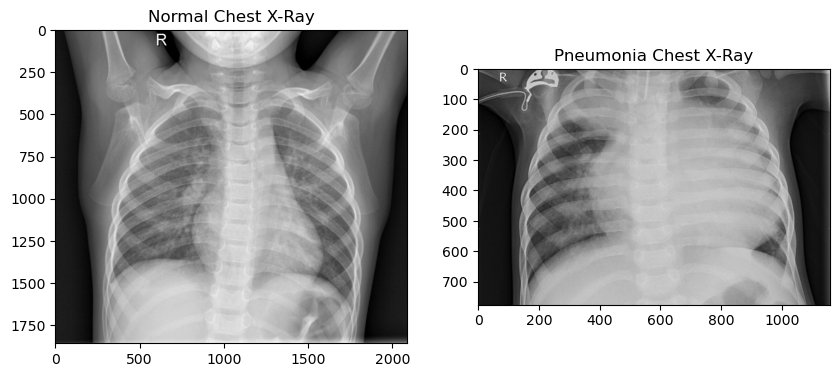

In [3]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(10,5)

image = cv2.imread('train/NORMAL/IM-0115-0001.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax[0].imshow(image)
ax[0].set_title('Normal Chest X-Ray')

image = cv2.imread('train/PNEUMONIA/person5_bacteria_19.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax[1].imshow(image)
ax[1].set_title('Pneumonia Chest X-Ray')
plt.show()

### Importing the libraries

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import pandas as pd
import seaborn as sns

## Part 1 - Data Preprocessing

### Distribution of the classes in each folder.

In [5]:
dic = {}

folders = ['train', 'test', 'val']
classes = ['PNEUMONIA', 'NORMAL']

for folder in folders:
    dic[folder] = {}
    for class_name in classes:
        count = len(os.listdir(f'{folder}/{class_name}'))
        dic[folder][class_name] = count

data = pd.DataFrame(dic)
print(data)

           train  test  val
PNEUMONIA   3875   390    8
NORMAL      1341   234    8


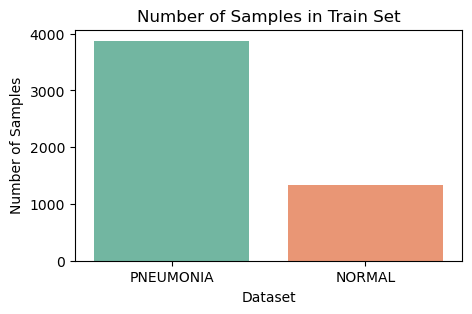

In [6]:
plt.figure(figsize=(5, 3))
sns.barplot(x=data.index, y=data.train.values, data=data, palette='Set2')
plt.title('Number of Samples in Train Set')
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.show()

Based on the plot it is clear that the data is unbalanced so in this case will be necessary to use callbacks to monitor the learning rate and avoid overfitting using Eaarly Stopping. 

### Preprocessing the Training set

#### Data Augmentation
**Data Augmentation** is applied only to the training set to create more diverse samples.

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range = 30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip = True)

* `rescale` is for normalizing the data for CNN to range from [0..1]
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures
vertically or horizontally.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal
asymmetry (e.g. real-world pictures).

In [8]:
train_set = train_datagen.flow_from_directory('train',
                                               target_size=(150, 150),
                                               batch_size=32,
                                               class_mode='binary',
                                               color_mode='grayscale',  
                                              )

Found 5216 images belonging to 2 classes.


**train_datagen.flow_from_directory:**
This function generates batches of tensor image data with real-time data augmentation. The data will be looped over (in batches) indefinitely.

**Parameters:**
* `train`: This is the path to the directory where your training images are stored. The directory have subdirectories for each class, with the subdirectory names being the class names.
* `target_size=(150, 150)`: This parameter resizes all images to the specified size (64x64 pixels) after they are loaded.
* `batch_size=32`: This specifies the number of images to be yielded from the generator per batch during the training process. Using a batch size of 32 means that the model will see 32 images at a time before updating the model parameters.
* `class_mode='binary`: This indicates the type of label arrays that are returned. With class_mode='binary'. This is used for binary classification problems.
* `color_mode='grayscalse`: This indicates if the image is going to be loaded as RGB or Grayscale.

### Preprocessing the Test set

In [9]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
test_set = test_datagen.flow_from_directory('test',
                                        target_size=(150, 150),
                                        batch_size=32,
                                        class_mode='binary',
                                        color_mode='grayscale',
                                        shuffle=False
                                       )

Found 624 images belonging to 2 classes.


### Preprocessing the Validation set

In [11]:
val_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
val_set = val_datagen.flow_from_directory('val',
                                        target_size=(150, 150),
                                        batch_size=32,
                                        class_mode='binary',
                                        color_mode='grayscale',
                                        shuffle=False
                                       )

Found 16 images belonging to 2 classes.


## Part 2 - Building the CNN

In [13]:
cnn = Sequential()

cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150, 150, 1)))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))

cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Dropout(0.1))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))

cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Dropout(0.1))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2, 2), strides = 2, padding='same'))

cnn.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))

cnn.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))

cnn.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))

cnn.add(Flatten())

cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(units=256, activation='relu'))
cnn.add(Dropout(0.2))

cnn.add(Dense(units=1, activation='sigmoid'))


C:\Users\audre\anaconda3\envs\ml_playground\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Parameters of Conv2D:

* `filters=32`: The number of filters in the convolutional layer. Each filter is a small matrix that slides over the input image to extract different features. In this case, there are 32 filters.
* `kernel_size=(3, 3)`: The size of the filters. A (3, 3) kernel means each filter is a 3x3 matrix. This determines the region of the input image that the filter looks at in each step.
* `activation='relu'`: The activation function applied to the output of the convolution operation. relu stands for Rectified Linear Unit, which introduces non-linearity to the model and helps in learning complex patterns. It replaces all negative values in the feature map with zero.
* `padding='same'`: This specifies that the input data and the output data will have the same size.
* `input_shape=(150, 150, 1)`: This specifies the shape of the input data. In this case, the input is a 150x150 pixel image with 1 channel (grayscale).

### Parameters of MaxPool2D:

* `pool_size=(2, 2)`: The size of the pooling window. A (2, 2) pool size means that each 2x2 block of the input feature map is considered, and the maximum value in each block is selected and passed to the output feature map.
* `strides=2`: This values indicates that the kernel defined will be moved 2 steps at the time.

### Batch Normalization: ###
It is a technique to normalize the inputs of each layer so that they have a mean of zero and a standard deviation of one. This is done to stabilize and speed up the training process. 

### Dense Layer Parameters
* `units=128`: This specifies that the layer will have 128 neurons.
* `activation='relu'`: This sets the activation function to ReLU (Rectified Linear Unit). ReLU activation function introduces non-linearity into the model, allowing it to learn complex patterns. It outputs the input directly if it is positive; otherwise, it will output zero.

### Droput Parameters
* `rate=0.2`: This specifies the dropout rate, which is the fraction of the input units to drop. In this case, 20% of the neurons will be randomly set to zero during each training step.

### Output Layer Parameters
* `units=1`: This specifies that the layer will have 1 neuron as output since we only need to classify the image as Pneumonia 1 - Normal 0.
* `activation='sigmoid'`: This sets the activation function to sigmoid. The sigmoid activation function maps input values to an output range between 0 and 1, making it useful for binary classification tasks by providing a smooth gradient for backpropagation.

## Part 3 - Training the CNN

### Compiling the CNN

In [29]:
cnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

### Compile Parameters
* `optimizer='rmsprop'`: RMSprop is a powerful optimizer that adapts learning rates dynamically based on the recent gradient history, making it well-suited for deep learning tasks, especially in cases where the data is noisy or where there is a need for rapid convergence.
* `loss='binary_crossentropy'`: Binary Cross-Entropy Loss: A common loss function used for binary classification tasks. It measures the performance of a classification model whose output is a probability value between 0 and 1.
* `metrics=['accuracy']`: Accuracy: A metric used to evaluate the model's performance. It calculates the percentage of correctly predicted instances out of the total instances. Using accuracy as a metric allows you to monitor how well the model is performing during training and validation.

In [15]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 2,232,385 (8.52 MB)

 Trainable params: 2,230,273 (8.51 MB)

 Non-trainable params: 2,112 (8.25 KB)

### Training the CNN and Evaluate Performance

### Adding Callbacks ###

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### EarlyStopping Callback
EarlyStopping callback is used to prevent overfitting and to save time by stopping the training once the model's performance stops improving. 

### Parameters
* `monitor='val_loss'`: This tells the callback to monitor the validation loss, which is a measure of how well the model is performing on unseen data.

* `patience=5`: This parameter allows the model to continue training for 5 more epochs after the last improvement in validation loss. If there’s no improvement for 5 consecutive epochs, training stops.

* `restore_best_weights=True`: After training stops, the model’s weights are reverted back to the point where the validation loss was the lowest. This ensures that you retain the best-performing model, even if some subsequent epochs caused the performance to worsen.

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-5)

### ReduceLROnPlateau Callback
ReduceLROnPlateau Callback reduce the learning rate during training if a specified metric has stopped improving. 

### Parameters
* `monitor='val_loss'`: This specifies the metric to be monitored. In this case, it's the validation accuracy. The learning rate will be reduced if the validation accuracy stops improving.
* `patience=3`: Number of epochs with no improvement after which learning rate will be reduced. Here, if the validation accuracy does not improve for 2 consecutive epochs, the learning rate will be reduced.
* `verbose=1`: This parameter controls the verbosity mode. If set to 1, a message will be printed to the console whenever the learning rate is reduced.
* `factor=0.3`: Factor by which the learning rate will be reduced. New learning rate = old learning rate * factor. Here, the learning rate will be multiplied by 0.3, effectively reducing it by 70%.
* `min_lr=0.000001`: The lower bound on the learning rate. The learning rate will not be reduced below this value.

## Training The Model

This step trains the CNN while monitoring its performance on validation data and automatically adjusting the learning rate or stopping early if needed. The training history (metrics for each epoch) is stored in history

In [17]:
history = cnn.fit(
    train_set,
    epochs=50,
    validation_data=val_set,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


C:\Users\audre\anaconda3\envs\ml_playground\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.7832 - loss: 0.7063 - val_accuracy: 0.5000 - val_loss: 14.2929 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.8738 - loss: 0.3011 - val_accuracy: 0.5000 - val_loss: 26.6387 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9182 - loss: 0.2106 - val_accuracy: 0.5000 - val_loss: 29.6624 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9303 - loss: 0.1830 - val_accuracy: 0.5000 - val_loss: 20.1969 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9539 - loss: 0.1300 - val_accuracy: 0.5000 - val_loss: 25.6217 - learning_rate: 3.0000e-04
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9574 - loss: 0.1347 - val_accuracy: 0.5625 - val_loss: 1.4070 - learning_rate: 3.0000e-04
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9596 - loss: 

### Parameters
* `train_set & val_set`: The training and validation datasets used for fitting the model.
* `epochs=50`: The model is set to train for up to 50 epochs (full passes over the training data).
* `validation_data=val_set`: The validation dataset is used to evaluate the model after each epoch.
* `callbacks=[early_stopping, reduce_lr]`: Two callbacks are applied:
* `early_stopping`: Stops training early if the validation loss doesn’t improve after a certain number of epochs (patience).
* `reduce_lr`: Reduces the learning rate if the model stops improving, helping to fine-tune the learning process.

### Performance Evaluation 

### Training and Validation Accuracy/Loss Plot:

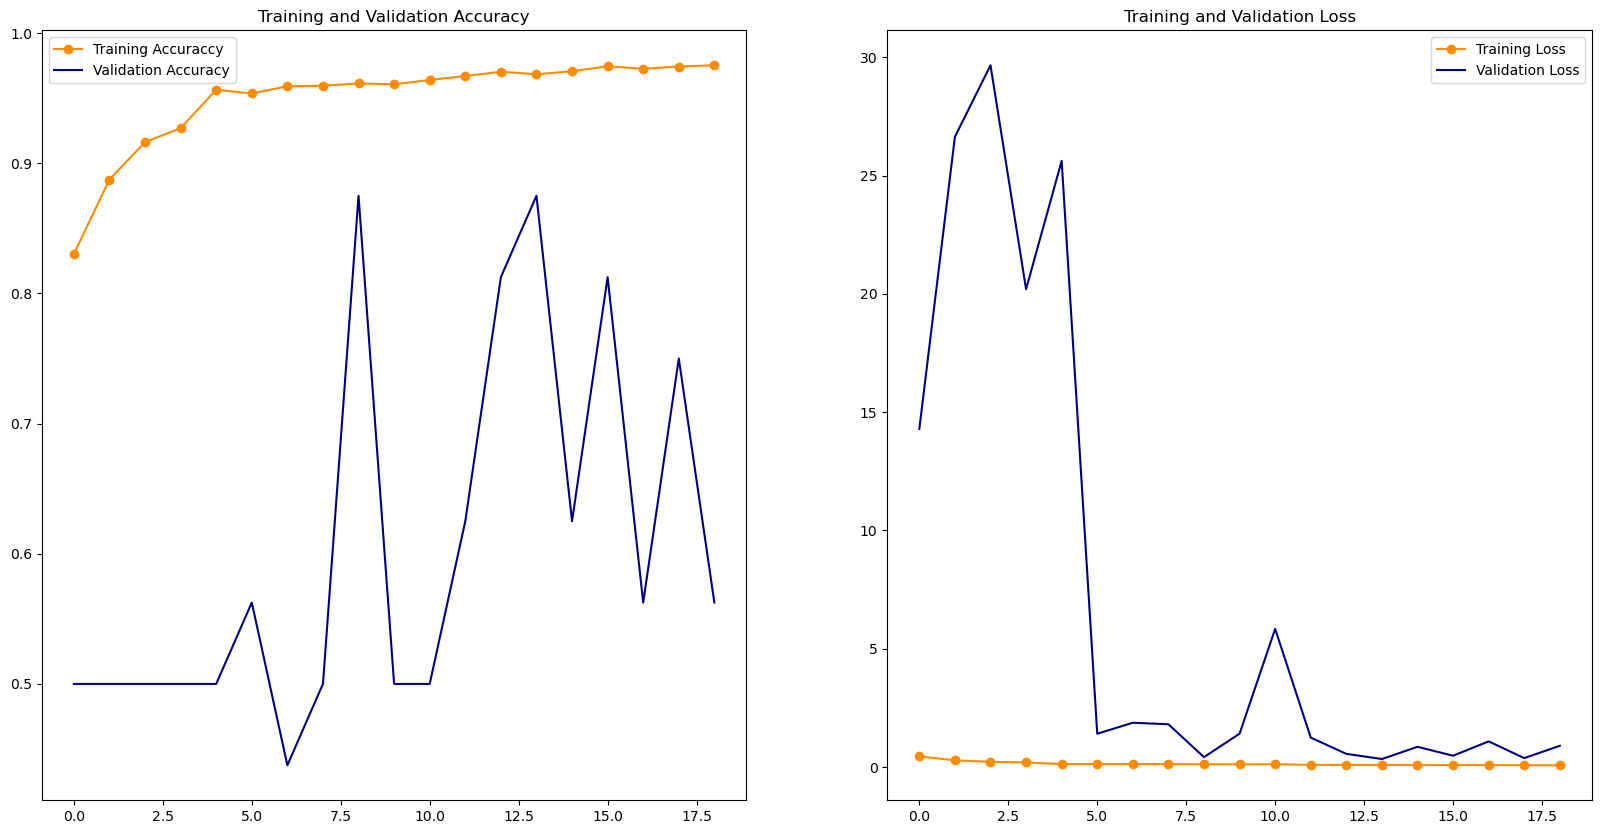

In [31]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


ax[0].plot(epochs, acc, color='darkorange', marker='o', label='Training Accuraccy')
ax[0].plot(epochs, val_acc, color='navy', label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, color='darkorange', marker='o', label='Training Loss')
ax[1].plot(epochs, val_loss, color='navy', label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()
plt.show()

### Test Set Evaluation

In [41]:
test_loss, test_acc = cnn.evaluate(test_set)
print(f'Loss of the model is {test_loss}')
print(f'Accuracy of the model is {test_acc * 100:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.9066 - loss: 0.3196
Loss of the model is 0.2500007450580597
Accuracy of the model is 91.99%


### Classification Report

In [42]:
test_set.reset()
predictions = cnn.predict(test_set)
predicted_classes = (predictions > 0.5).astype(int)

real_classes = test_set.classes

report = classification_report(real_classes, predicted_classes, target_names=test_set.class_indices.keys())
print(report)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step
              precision    recall  f1-score   support

      NORMAL       0.90      0.88      0.89       234
   PNEUMONIA       0.93      0.94      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624



### Confusion Matrix

In [43]:
matrix = confusion_matrix(real_classes, predicted_classes)
print(matrix)

[[206  28]
 [ 22 368]]


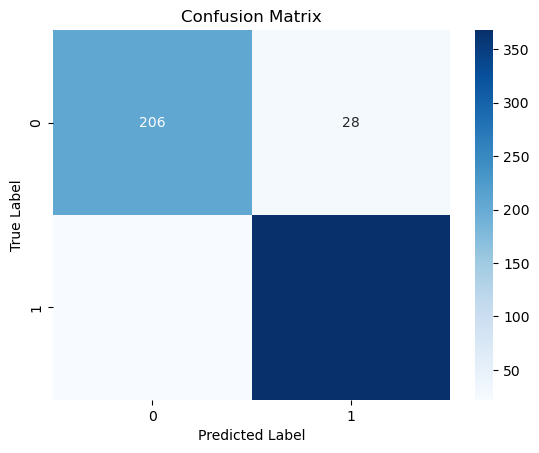

In [44]:
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Plot ROC Curve

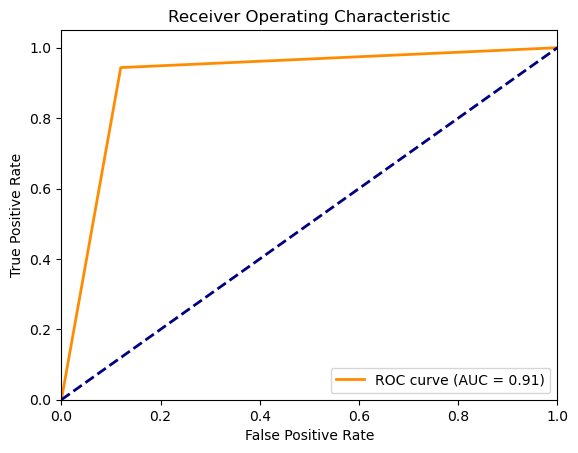

In [23]:
fpr, tpr, _ = roc_curve(real_classes, predicted_classes)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

A ROC curve that is closer to the top-left corner indicates a better-performing model. Here, the TPR is high, and the FPR is low, meaning the model correctly identifies most positive cases while minimizing false positives.

AUC = 0.91:
Which means that it has a 91% chance of correctly distinguishing between a random positive case (pneumonia) and a random negative case (normal).
This high AUC suggests that the model is performing very well, with a strong ability to separate the two classes.

## Part 4 - Making final predictions

In [24]:
def display_images_with_predictions(validation_set, predictions, class_labels, real_labels, num_images=16):
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    axes = axes.flatten()
    for img, pred, lbl, ax in zip(validation_set.filenames, predictions, real_labels, axes):
        img_path = os.path.join(validation_set.directory, img)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        if lbl == 0 :
            real_lbl = "NORMAL"
        else:
            real_lbl = "PNEUMONIA"
        pred_label = class_labels[pred[0]]
        ax.set_title(f'Pred: {pred_label} - Real: {real_lbl}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [25]:
val_set.reset()
val_predictions = cnn.predict(val_set)
val_predicted_classes = (val_predictions > 0.5).astype(int)
real_labels = val_set.labels
real_classes = val_set.classes
class_indices = val_set.class_indices
class_labels = {v: k for k, v in class_indices.items()}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


In [26]:
report = classification_report(real_classes, val_predicted_classes, target_names=val_set.class_indices.keys())
print(report)

              precision    recall  f1-score   support

      NORMAL       1.00      0.75      0.86         8
   PNEUMONIA       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



In [27]:
matrix = confusion_matrix(real_classes, val_predicted_classes)
print(matrix)

[[6 2]
 [0 8]]


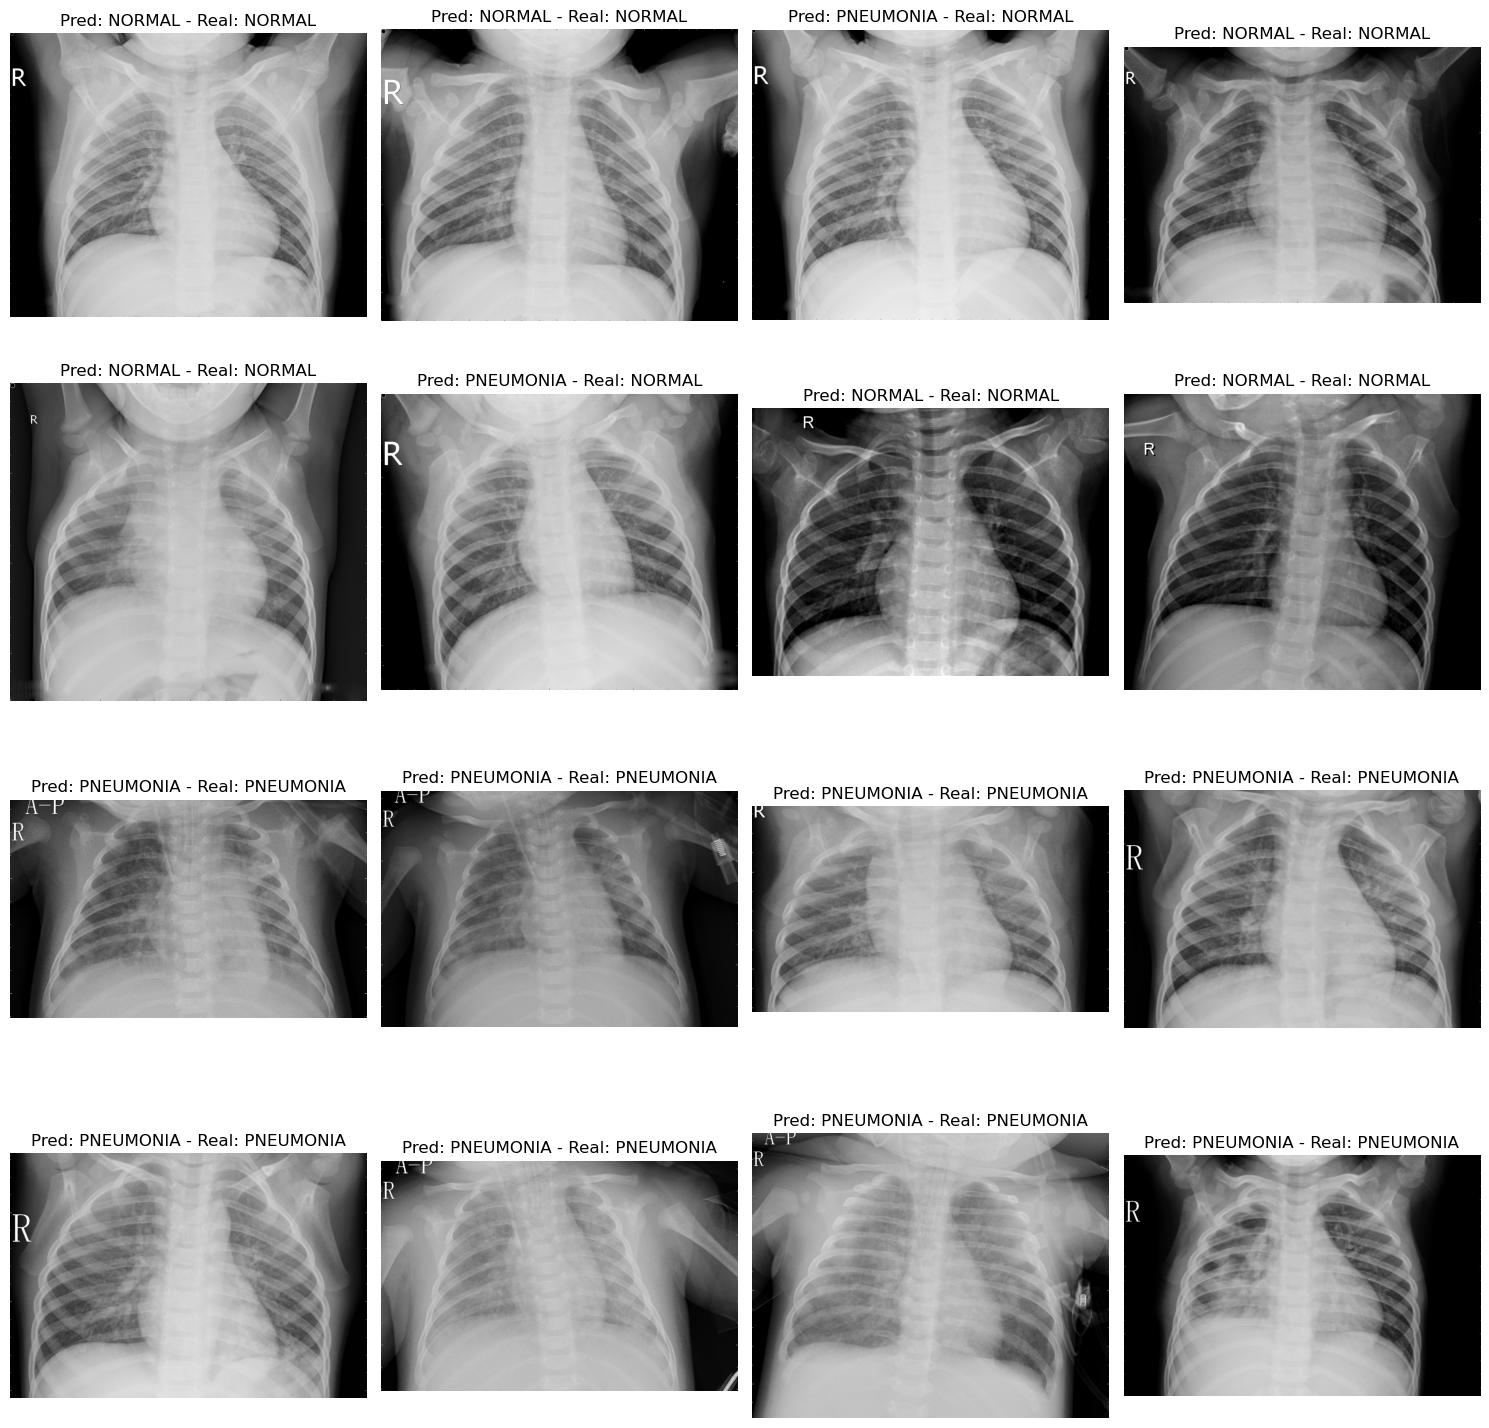

In [28]:
display_images_with_predictions(val_set, val_predicted_classes, class_labels, real_labels)

## Part 5 - Conclusion

In this project, we developed a Convolutional Neural Network (CNN) to detect pneumonia from chest X-ray images. The final model achieved a test accuracy of 92% and an AUC of 0.91, indicating strong performance in distinguishing between pneumonia and normal cases. Through experimentation, we found that while L2 regularization slightly reduced overfitting, it led to lower overall performance compared to the original model. The results demonstrate the model is able to detect Pneumonia with a slightly higher rate for Type II errors over the Type I error.